In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
data_raw = pd.read_csv('/content/drive/MyDrive/Datasets/sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('/content/drive/MyDrive/Datasets/sign_mnist_test.csv', sep=",")

labels = data_raw['label']
data_raw.drop('label', axis=1, inplace=True)
labels_test = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True)

data = data_raw.values
labels = labels.values
test_data = test_data_raw.values
labels_test = labels_test.values

<Axes: >

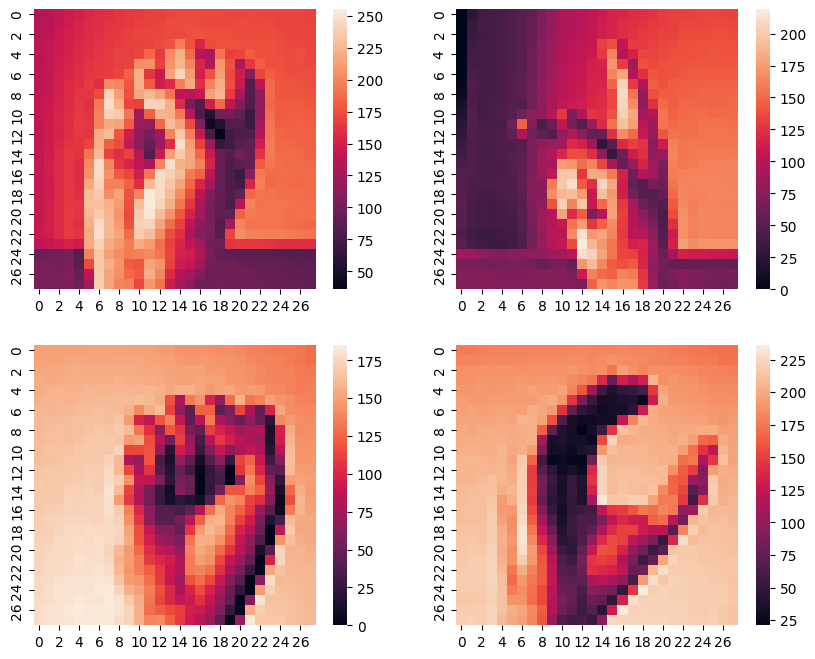

In [3]:
plt.figure(figsize=(10, 8))

pixels = data[10].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)

pixels = data[11].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)

pixels = data[20].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)

pixels = data[32].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)

In [4]:
import string

alph = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:"f", 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n',
        14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'}

In [5]:
def reshape_to_2d(data, dim):
    reshaped = []
    for i in data:
        reshaped.append(i.reshape(1, dim, dim))

    return np.array(reshaped)

In [6]:
data = reshape_to_2d(data, 28)

x = torch.FloatTensor(data)
y = torch.LongTensor(labels.tolist())

test_labels = torch.LongTensor(labels_test.tolist())

test_data_formated = reshape_to_2d(test_data, 28)
test_data_formated = torch.FloatTensor(test_data_formated)

In [7]:
epochs = 50
batch_size = 100
learning_rate = 0.001


In [8]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(20, 30, 3)
        self.dropout1 = nn.Dropout2d()

        self.fc3 = nn.Linear(30 * 3 * 3, 270)
        self.fc4 = nn.Linear(270, 26)

        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = x.view(-1, 30 * 3 * 3)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        return self.softmax(x)


    def test(self, predictions, labels):

        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1

        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))


    def evaluate(self, predictions, labels):

        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1

        acc = correct / len(predictions)
        return(acc)

In [9]:
net = Network()
print(net)

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=270, out_features=270, bias=True)
  (fc4): Linear(in_features=270, out_features=26, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [10]:
optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.7)
loss_func = nn.CrossEntropyLoss()

In [11]:
loss_log = []
acc_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size]
        y_mini = y[i:i + batch_size]

        optimizer.zero_grad()
        net_out = net(Variable(x_mini))

        loss = loss_func(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(net.evaluate(torch.max(net(Variable(test_data_formated[:500])).data, 1)[1],
                                        test_labels[:500]))

    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 2.929516
Epoch: 2 - Loss: 2.244643
Epoch: 3 - Loss: 1.808713
Epoch: 4 - Loss: 1.209185
Epoch: 5 - Loss: 1.164961
Epoch: 6 - Loss: 0.906336
Epoch: 7 - Loss: 0.744517
Epoch: 8 - Loss: 0.723130
Epoch: 9 - Loss: 0.922919
Epoch: 10 - Loss: 0.426729
Epoch: 11 - Loss: 0.667450
Epoch: 12 - Loss: 0.503936
Epoch: 13 - Loss: 0.495577
Epoch: 14 - Loss: 0.452067
Epoch: 15 - Loss: 0.348316
Epoch: 16 - Loss: 0.216204
Epoch: 17 - Loss: 0.324355
Epoch: 18 - Loss: 0.180480
Epoch: 19 - Loss: 0.365420
Epoch: 20 - Loss: 0.423003
Epoch: 21 - Loss: 0.259918
Epoch: 22 - Loss: 0.239288
Epoch: 23 - Loss: 0.148653
Epoch: 24 - Loss: 0.214463
Epoch: 25 - Loss: 0.057091
Epoch: 26 - Loss: 0.160902
Epoch: 27 - Loss: 0.119497
Epoch: 28 - Loss: 0.073077
Epoch: 29 - Loss: 0.176497
Epoch: 30 - Loss: 0.086119
Epoch: 31 - Loss: 0.208725
Epoch: 32 - Loss: 0.152524
Epoch: 33 - Loss: 0.203231
Epoch: 34 - Loss: 0.113087
Epoch: 35 - Loss: 0.251821
Epoch: 36 - Loss: 0.132899
Epoch: 37 - Loss: 0.087235
Epoch: 38 

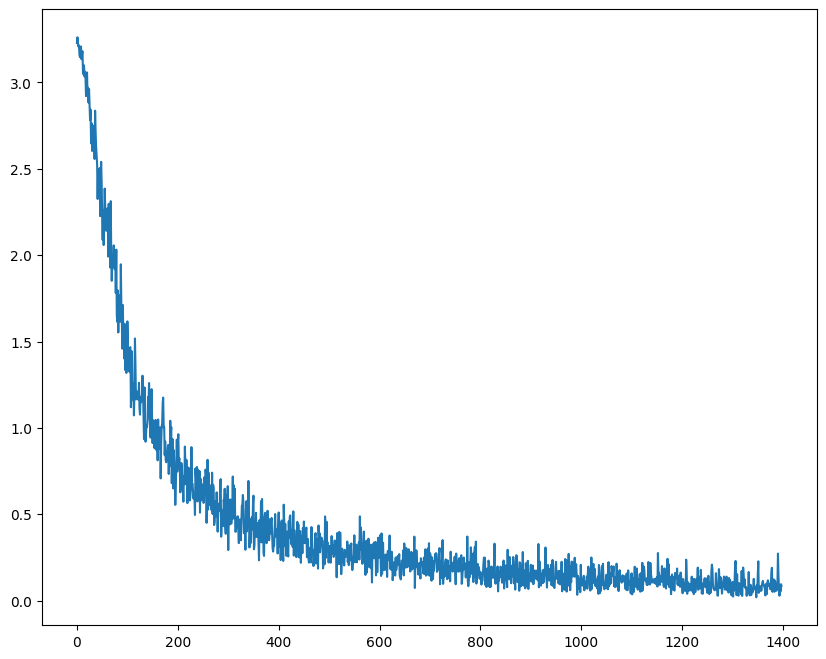

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])


In [13]:
predictions = net(Variable(test_data_formated))
net.test(torch.max(predictions.data, 1)[1], test_labels)


Correct predictions:  5857 /  7172 (0.816648)
